* [Exercise 6.7: Windy Gridworld with King’s Moves](#Exercise-6.7:-Windy-Gridworld-with-King’s-Moves)

## Exercise 6.7: Windy Gridworld with King’s Moves

### Create Windy Grid World environment

In [1]:
import numpy as np

In [2]:
ACTION_TO_XY = {
    'left': (-1, 0),
    'right': (1, 0),
    'up': (0, 1),
    'down': (0, -1),
    'up_left': (-1, 1),
    'down_left': (-1, -1),
    'up_right': (1, 1),
    'down_right': (1, -1),
    'stop': (0, 0)
}

# convert tuples to np so we can do math with states
ACTION_TO_XY = {a: np.array(xy) for a, xy in ACTION_TO_XY.items()}

In [3]:
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

In [4]:
class WindyGridworld(object):
    def __init__(self):
        self._state = None
        self._goal = np.array([7, 3]) # goal state, XY
        self._start = np.array([0, 3]) # start state, XY
        self.shape = [10, 7] # grid world shape, XY
        self._wind_x = WIND
        assert len(self._wind_x) == self.shape[0]
        
    def reset(self):
        self._state = self._start.copy()
        return tuple(self._state)
        
    def _clip_state(self):        
        self._state[0] = np.clip(self._state[0], 0, self.shape[0] - 1) # clip x
        self._state[1] = np.clip(self._state[1], 0, self.shape[1] - 1) # clip y
        
    def step(self, action):
        a_xy = ACTION_TO_XY[action]
        
        # apply wind shift
        wind_shift = [0, self._wind_x[self._state[0]]]
        self._state += np.array(wind_shift)
        self._clip_state()
        # apply action
        self._state += a_xy
        self._clip_state()
        
        
        reward = -1
        term = True if np.all(self._goal == self._state) else False
        
        return tuple(self._state), reward, term, None

### Create Sarsa Agent

In [5]:
from collections import defaultdict, namedtuple
import random
from tqdm import tqdm

In [6]:
Transition = namedtuple('Transition', ['state1',
                                       'action',
                                       'reward',
                                       'state2'])

In [7]:
class SarsaAgent(object):
    def __init__(self, env, actions, alpha=0.5, epsilon=0.1, gamma=1):
        self._env = env
        self._actions = actions
        self._alpha = alpha
        self._epsilon = epsilon
        self._gamma = gamma        
        self.episodes = []
        # init q table
        self._q = {}
        action_vals = {a: 0 for a in self._actions}
        for x in range(self._env.shape[0]):
            for y in range(self._env.shape[1]):
                self._q[(x,y)] = dict(action_vals)
    
    def random_policy(self, state):
        return random.choice(self._actions)
            
    def greedy_policy(self, state):
        return max(self._q[state], key=self._q[state].get)
        
    def e_greedy_policy(self, state):
        if np.random.rand() > self._epsilon:
            action = self.greedy_policy(state)
        else:
            action = self.random_policy(state)
        return action

    def play_episode(self):
        s1 = self._env.reset()
        a1 = self.e_greedy_policy(s1)
        transitions = []
        while True:
            s2, r, term, _ = self._env.step(a1)
            a2 = self.e_greedy_policy(s2)
            
            target = r + self._gamma*self._q[s2][a2]
            if term:
                target = 0.0
            self._q[s1][a1] = self._q[s1][a1] + self._alpha*(target - self._q[s1][a1])
            s1 = s2
            a1 = a2

            transitions.append(Transition(s1, a1, r, s2))
            
            if term:
                break
        return transitions
    
    def learn(self, n_episodes=500):
        for _ in tqdm(range(n_episodes)):
            transitions = self.play_episode()
            self.episodes.append(transitions)

### Evaluate agents with different action set

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
actions4 = ['left', 'right', 'up', 'down']
actions8 = ['left', 'right', 'up', 'down', 'up_left', 'down_left', 'up_right', 'down_right']
actions9 = ['left', 'right', 'up', 'down', 'up_left', 'down_left', 'up_right', 'down_right', 'stop']

In [10]:
ACTION_TO_ARROW = {
    'left': '⇽',
    'right': '→',
    'up': '↑',
    'down': '↓',
    'up_left': '↖',
    'down_left': '↙',
    'up_right': '↗',
    'down_right': '↘',
    'stop': '○'
}

In [11]:
def evaluate(agent, title):
    agent.learn()
    
    total_rewards = []
    episode_ids = []
    for e_id, episode in enumerate(agent.episodes):
        rewards = map(lambda e: e.reward, episode)
        total_rewards.append(sum(rewards))
        episode_ids.extend([e_id] * len(episode))

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # display total reward vs episodes
    ax = axs[0]
    ax.plot(total_rewards)
    ax.grid()
    ax.set_title(title)
    ax.set_xlabel('episode')
    ax.set_ylabel('Total rewards')
    
    # display time steps vs episodes
    ax = axs[1]
    ax.plot(episode_ids)
    ax.grid()
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Episodes')
    
    q = agent._q
    for y in range(agent._env.shape[1] - 1, -1, -1):
        row = []
        for x in range(agent._env.shape[0]):
            state = (x,y)
            a = max(q[state], key=q[state].get)
            row.append(ACTION_TO_ARROW[a])
            # row.append(a)
        print(row)
    print([str(w) for w in WIND])

In [12]:
world = WindyGridworld()

100%|██████████| 500/500 [00:00<00:00, 1128.73it/s]


['↓', '→', '↓', '→', '→', '→', '→', '→', '→', '↓']
['→', '→', '↑', '→', '→', '→', '→', '→', '→', '↓']
['→', '→', '→', '→', '→', '→', '→', '→', '↑', '↓']
['→', '→', '→', '→', '→', '→', '→', '⇽', '→', '↓']
['→', '→', '→', '→', '→', '→', '⇽', '↓', '⇽', '⇽']
['⇽', '→', '↓', '→', '→', '⇽', '⇽', '↓', '⇽', '↓']
['→', '→', '→', '→', '⇽', '⇽', '⇽', '⇽', '⇽', '⇽']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


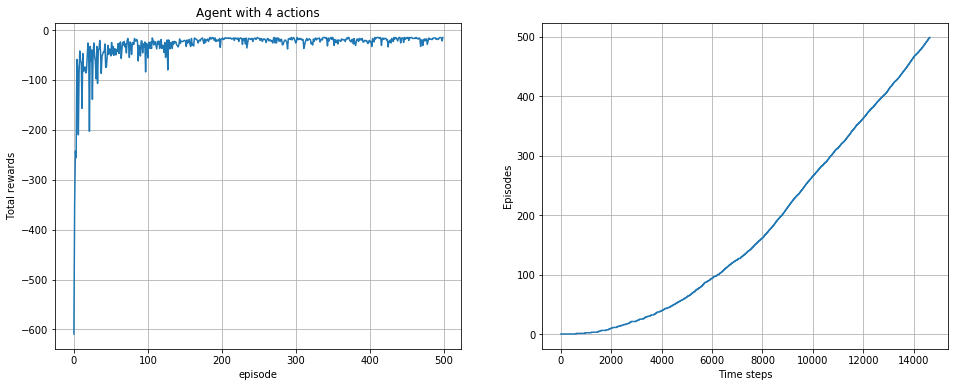

In [13]:
agent4 = SarsaAgent(world, actions4)
evaluate(agent4, 'Agent with 4 actions')

100%|██████████| 500/500 [00:00<00:00, 1593.88it/s]


['↘', '↖', '⇽', '↙', '↖', '→', '↗', '→', '↘', '↘']
['↘', '↙', '↓', '↘', '↘', '→', '↘', '→', '↑', '↓']
['↑', '↘', '↓', '↖', '↘', '→', '→', '→', '↘', '↘']
['↓', '↘', '↘', '↓', '↘', '↘', '↘', '⇽', '↙', '⇽']
['↘', '↓', '→', '↘', '↘', '↘', '↘', '→', '⇽', '↗']
['↖', '↘', '↘', '↘', '→', '↘', '→', '↑', '↖', '↘']
['↑', '↘', '↓', '↖', '↘', '↘', '↗', '⇽', '↑', '→']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


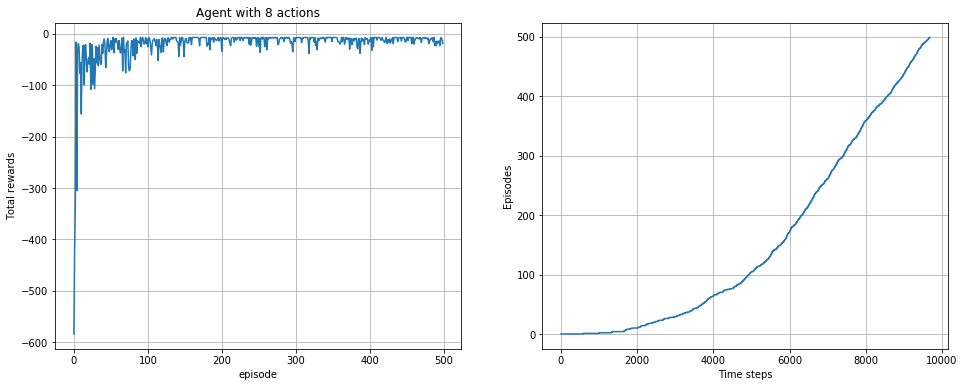

In [14]:
agent8 = SarsaAgent(world, actions8)
evaluate(agent8, 'Agent with 8 actions')

100%|██████████| 500/500 [00:00<00:00, 1472.64it/s]


['→', '↘', '→', '↘', '↘', '→', '↘', '→', '↘', '↘']
['↑', '→', '⇽', '↘', '↘', '→', '→', '→', '↘', '↓']
['↘', '↘', '↓', '↘', '↗', '↗', '→', '↙', '↘', '↙']
['↓', '→', '↘', '⇽', '↙', '↘', '↘', '⇽', '↙', '↙']
['↘', '↑', '↓', '↘', '↘', '↘', '↘', '↑', '⇽', '↙']
['↘', '↘', '↘', '↘', '↘', '↘', '→', '↑', '↑', '↖']
['↓', '↘', '↗', '↘', '↘', '→', '↗', '⇽', '→', '→']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


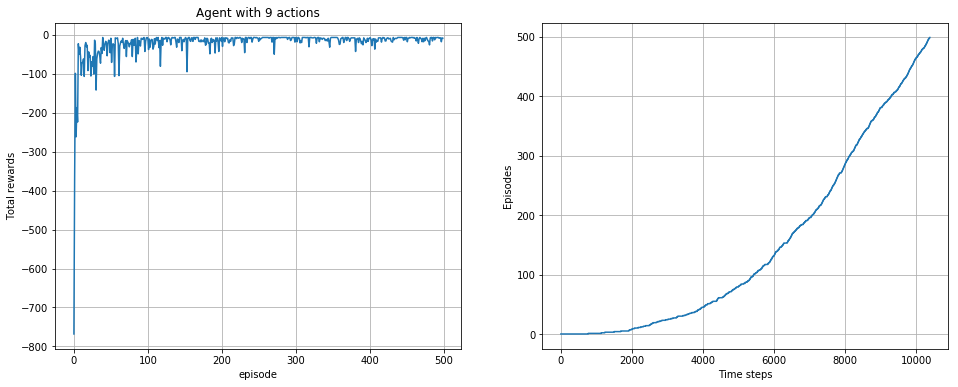

In [15]:
agent9 = SarsaAgent(world, actions9)
evaluate(agent9, 'Agent with 9 actions')

## Exercise 6.8: Stochastic Wind

In [17]:
class StochasticWindyGridworld(WindyGridworld):        
    def step(self, action):
        a_xy = ACTION_TO_XY[action]
        
        # apply wind shift
        wind = self._wind_x[self._state[0]]
        if wind > 0:
            wind = random.choice([wind - 1, wind, wind + 1])
        wind_shift = [0, wind]
        self._state += np.array(wind_shift)
        self._clip_state()
        # apply action
        self._state += a_xy
        self._clip_state()
        
        reward = -1
        term = True if np.all(self._goal == self._state) else False
        
        return tuple(self._state), reward, term, None

In [18]:
stochastic_world = StochasticWindyGridworld()

100%|██████████| 500/500 [00:01<00:00, 484.85it/s]


['↓', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
['→', '→', '→', '→', '→', '⇽', '→', '→', '→', '↓']
['↓', '↓', '↓', '→', '→', '↓', '→', '→', '↓', '↓']
['→', '→', '↓', '→', '↓', '→', '↑', '⇽', '⇽', '↓']
['→', '→', '→', '→', '→', '→', '→', '↓', '→', '↓']
['↓', '→', '↓', '↑', '→', '↓', '→', '↓', '↓', '→']
['→', '→', '→', '→', '↓', '→', '→', '→', '⇽', '↑']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


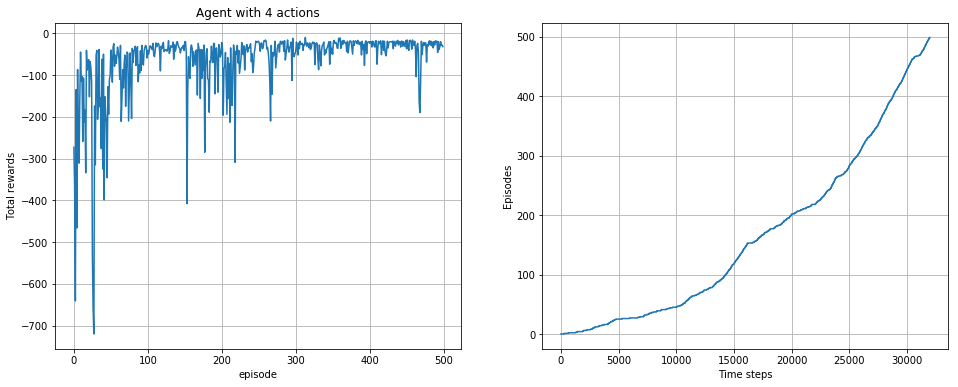

In [22]:
agent4 = SarsaAgent(stochastic_world, actions4)
evaluate(agent4, 'Agent with 4 actions')

100%|██████████| 500/500 [00:00<00:00, 502.92it/s]


['↓', '↗', '↗', '↖', '↗', '↗', '↗', '↘', '⇽', '↓']
['↓', '↖', '↙', '→', '↘', '↘', '↗', '↗', '↘', '↓']
['↘', '↓', '⇽', '↖', '→', '→', '↑', '↘', '↘', '↓']
['→', '↘', '⇽', '→', '↘', '→', '↘', '⇽', '↙', '↙']
['→', '→', '→', '↘', '↘', '↘', '↘', '↘', '↙', '↑']
['↘', '↘', '↘', '↘', '↘', '↘', '↘', '→', '↖', '→']
['→', '→', '→', '↘', '↘', '↘', '↘', '⇽', '↖', '⇽']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


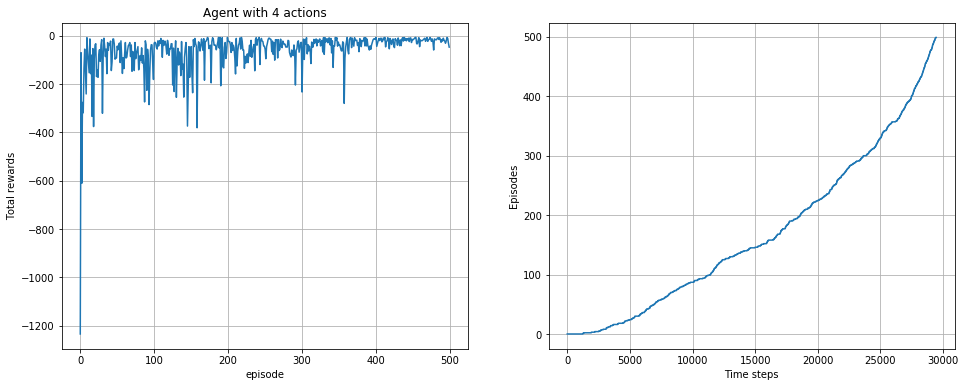

In [23]:
agent8 = SarsaAgent(stochastic_world, actions8)
evaluate(agent8, 'Agent with 8 actions')

100%|██████████| 500/500 [00:01<00:00, 404.30it/s]


['→', '○', '↘', '↘', '↓', '↗', '↘', '↗', '↘', '↘']
['⇽', '→', '↘', '↘', '↘', '↗', '↗', '↘', '↘', '↘']
['↙', '⇽', '↓', '↗', '↓', '↘', '↖', '↘', '↙', '⇽']
['↘', '↙', '↙', '↖', '⇽', '↘', '○', '⇽', '↖', '↙']
['↙', '↘', '→', '○', '↘', '↘', '↗', '↗', '↙', '↘']
['↘', '↘', '↘', '↖', '↗', '↘', '↘', '↘', '→', '↙']
['↗', '⇽', '↘', '↘', '↘', '↖', '↘', '↑', '↙', '↙']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


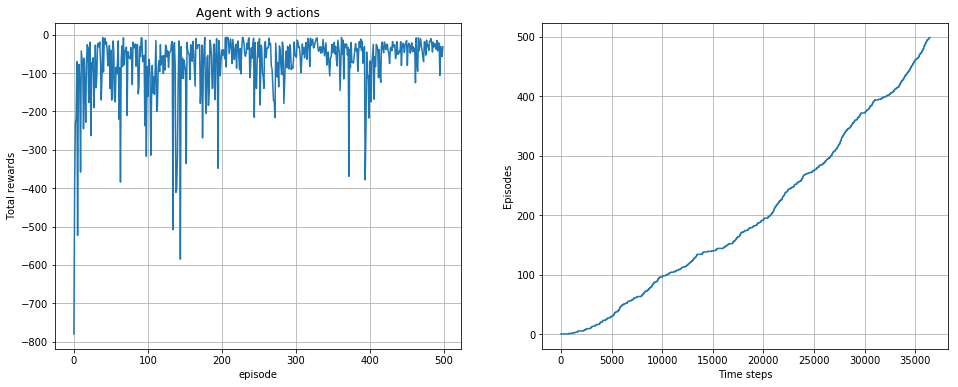

In [24]:
agent9 = SarsaAgent(stochastic_world, actions9)
evaluate(agent9, 'Agent with 9 actions')